In [70]:

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# DATA FILES

price_files = ["bittensor_token_price.csv", "fetchai_token_price.csv",
               "numerai_token_price.csv", "oceanprotocol_token_price.csv",
               "oraichain_token_price.csv", "singularitynet_token_price.csv"]

commits_mapping = {
    "bittensor_commits.json": "TAO",
    "fetchai_commits.json": "FET",
    "numerai_commits.json": "NMR", 
    "oceanprotocol_commits.json": "OCEAN",
    "oraichain_commits.json": "ORAI",
    "singularitynet_commits.json": "AGIX"
}

repos_mapping = {
    "bittensor_repos.json": "TAO",
    "fetchai_repos.json": "FET",
    "numerai_repos.json": "NMR", 
    "oceanprotocol_repos.json": "OCEAN",
    "oraichain_repos.json": "ORAI",
    "singularitynet_repos.json": "AGIX"
}

tokens = ["TAO", "FET", "NMR",
          "OCEAN", "ORAI", "AGIX"]


In [48]:
# IDEA: Use get_commits to extract the df with commit_data
# Kind of group by author.name (developer) and count the commits by trend
# apply the project_rank plot

def get_commits(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'github_data/{k}'
            with open(filename) as commits_file:
                parsed_json = json.load(commits_file)
            
            commits_rows = [row for sublist in parsed_json for row in sublist]
            commits_df = pd.DataFrame(commits_rows)
            return commits_df
    return f'No commit data for token {token}'


def get_commit_trends(commits_df):
    # Flatten JSON data for commit and author
    flat_commit = pd.json_normalize(commits_df['commit'])
    flat_author = pd.json_normalize(commits_df['author'])
    commits_df = pd.concat([commits_df, flat_commit], axis=1)
    commits_df = pd.concat([commits_df, flat_author], axis=1)
    commits_df.drop(columns=['commit', 'author'], inplace=True)

    # Convert author date to datetime and extract date part
    commits_df['author.date'] = pd.to_datetime(commits_df['author.date']).dt.date
    
    # Count occurrences by date and ID
    date_counts = commits_df.groupby(['author.date', 'id']).size().reset_index(name='count')
    
    # Merge with author names
    single_ids = commits_df[['id', 'author.name']].drop_duplicates()
    date_counts = pd.merge(date_counts, single_ids, on='id', how='left')
    
    # Convert 'author.date' column to datetime
    date_counts['author.date'] = pd.to_datetime(date_counts['author.date'])
    date_counts['year'] = date_counts['author.date'].dt.year

    # Resampling helper function
    def resample_data(df, freq):
        resampled = df.set_index('author.date').groupby('id').resample(freq)['count'].sum().reset_index()
        return pd.merge(resampled, single_ids, on='id', how='left')

    # Resample into yearly, monthly, and weekly intervals
    yearly_counts = resample_data(date_counts, 'Y')
    monthly_counts = resample_data(date_counts, 'M')
    weekly_counts = resample_data(date_counts, 'W')

    return yearly_counts, monthly_counts, weekly_counts



In [75]:
def preprocess_trends(commits_df, token):
    dev_rank = pd.DataFrame()
    dev_rank['date'] = commits_df['author.date']
    dev_rank['year'] = commits_df['author.date'].dt.year
    dev_rank['week'] = commits_df['author.date'].dt.isocalendar().week
    dev_rank['total'] = commits_df.groupby(['id', 'author.date'])['count'].cumsum().values
    dev_rank['id'] = commits_df['id']
    dev_rank['author.name'] = commits_df['author.name']
    dev_rank['project'] = token

    return dev_rank

def plot_evolution_graph(rank_df, time_frame, token):
    # Rank developers based on the total for each date
    rank_df['rank'] = rank_df.groupby('date')['total'].rank(method='first', ascending=False)
    
    # Filter to top 10 ranks at each date
    top_rank_df = rank_df.groupby('date').apply(lambda x: x.nsmallest(10, 'rank')).reset_index(drop=True)

    # Aggregate counts to handle duplicates
    top_rank_df = top_rank_df.groupby(['date', 'id', 'author.name'], as_index=False)['total'].sum()

    # Recompute ranks after aggregation
    top_rank_df['rank'] = top_rank_df.groupby('date')['total'].rank(method='first', ascending=False)

    # Ensure 'date' is a string to use as x-tick labels
    top_rank_df['date'] = top_rank_df['date'].astype(str)

    # Pivot the data to get the rank evolution for each developer
    rank_evolution = top_rank_df.pivot_table(index='date', columns='id', values='rank', aggfunc='first')

    author_names = top_rank_df.set_index('id')['author.name'].to_dict()

    # Generate unique colors for each developer
    unique_ids = rank_evolution.columns
    num_developers = len(unique_ids)
    colors = list(mcolors.TABLEAU_COLORS.values())
    if num_developers > len(colors):
        colors = plt.cm.get_cmap('tab20', num_developers).colors
    color_map = {dev_id: colors[i] for i, dev_id in enumerate(unique_ids)}

    # Plot the evolution of developer rankings over time
    plt.figure(figsize=(12, 8))
    for dev_id in rank_evolution.columns:
        plt.plot(rank_evolution.index, rank_evolution[dev_id], marker='o', label=author_names.get(dev_id, 'Unknown'), color=color_map[dev_id])


    plt.ylim(0.1, 12)  # Set y-axis limits to the number of projects
    plt.gca().invert_yaxis()  # Invert y-axis to show rank 1 at the top
    plt.xlabel('Date')
    plt.ylabel('Rank')
    plt.title(f'{time_frame} Evolution of Developer Rankings on {token} Based on Cumulative Commits')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


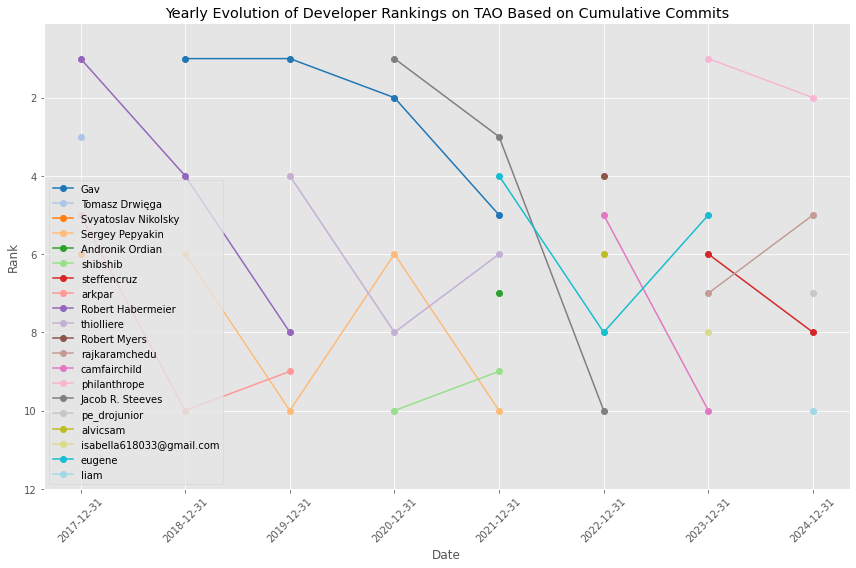

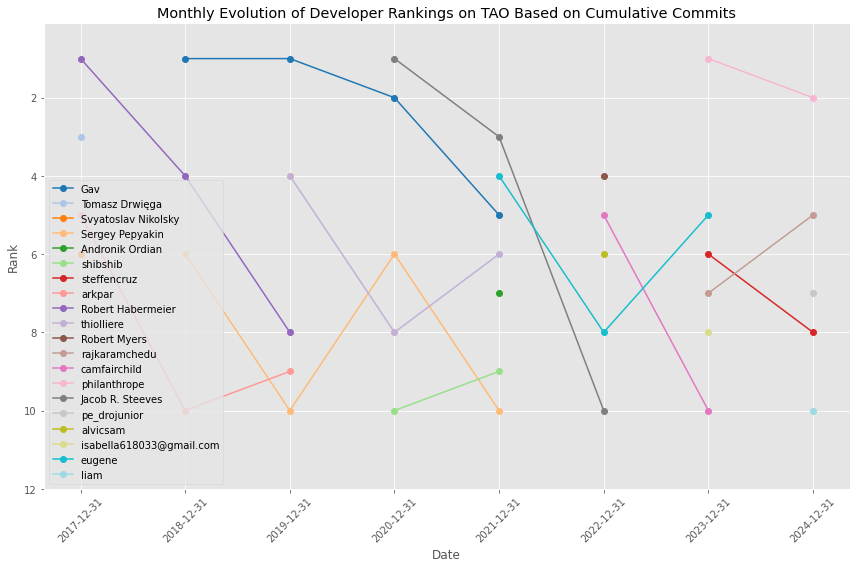

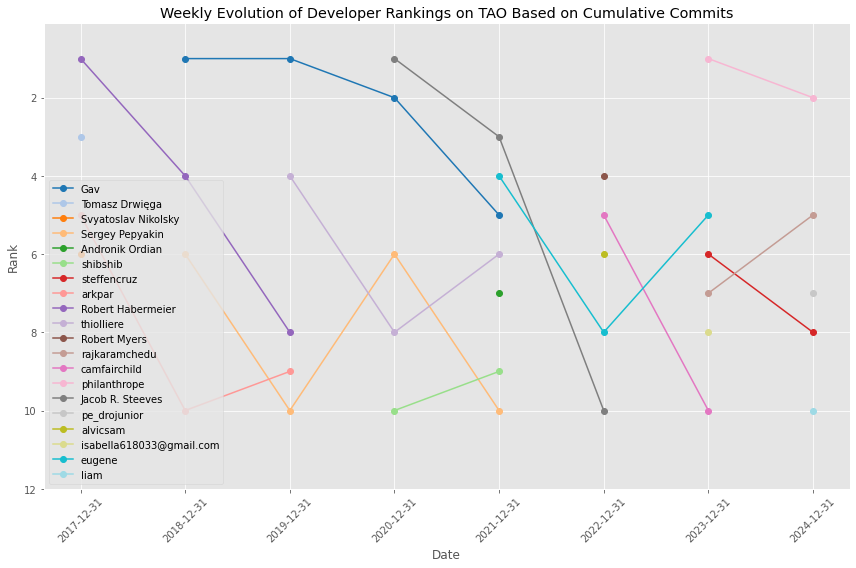

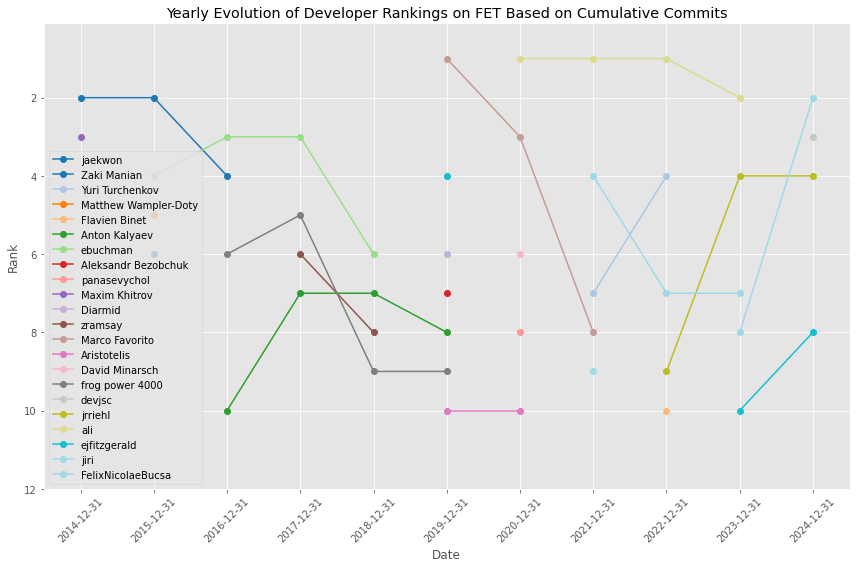

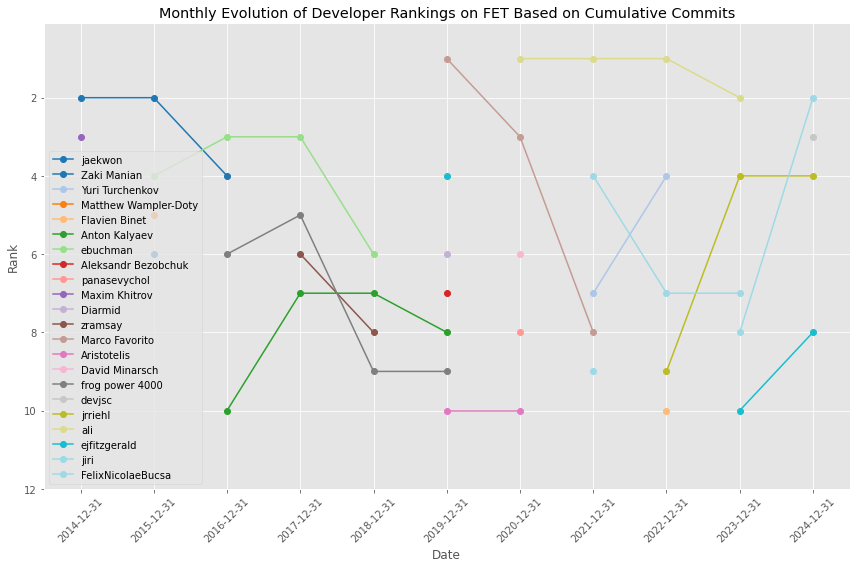

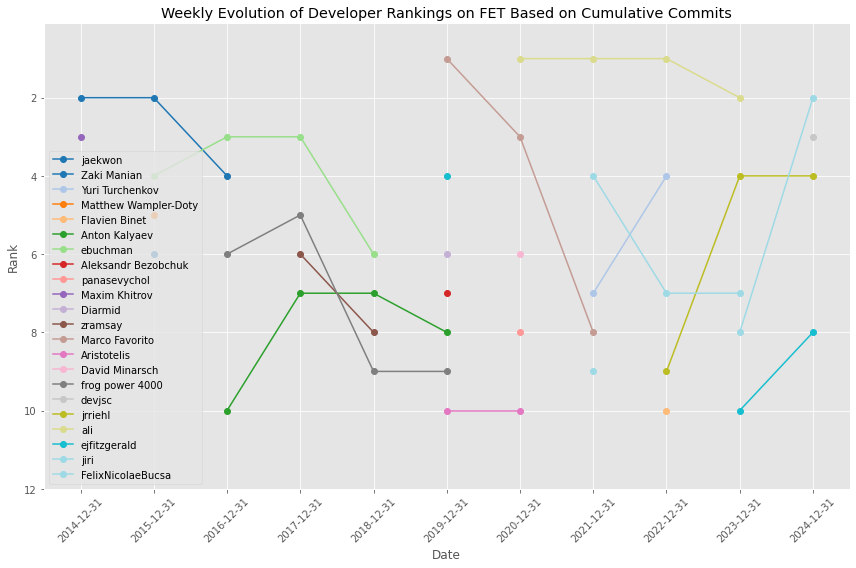

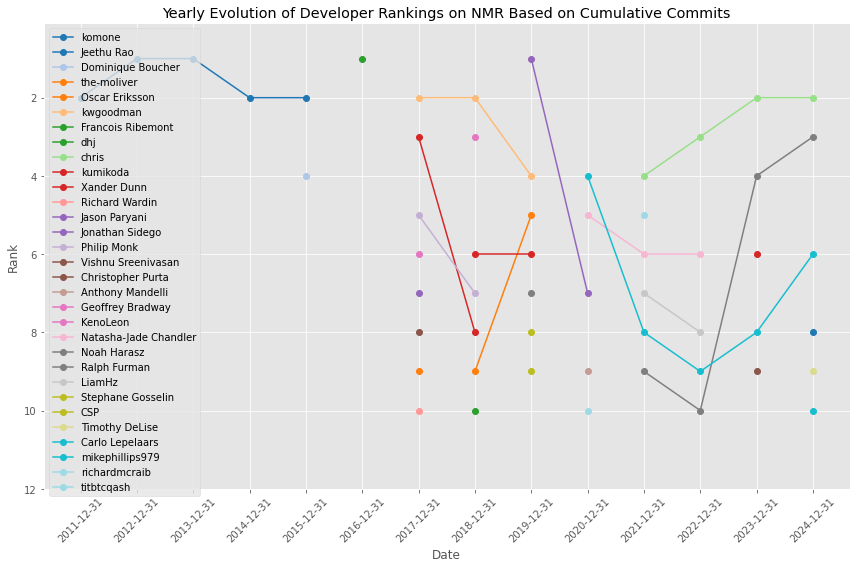

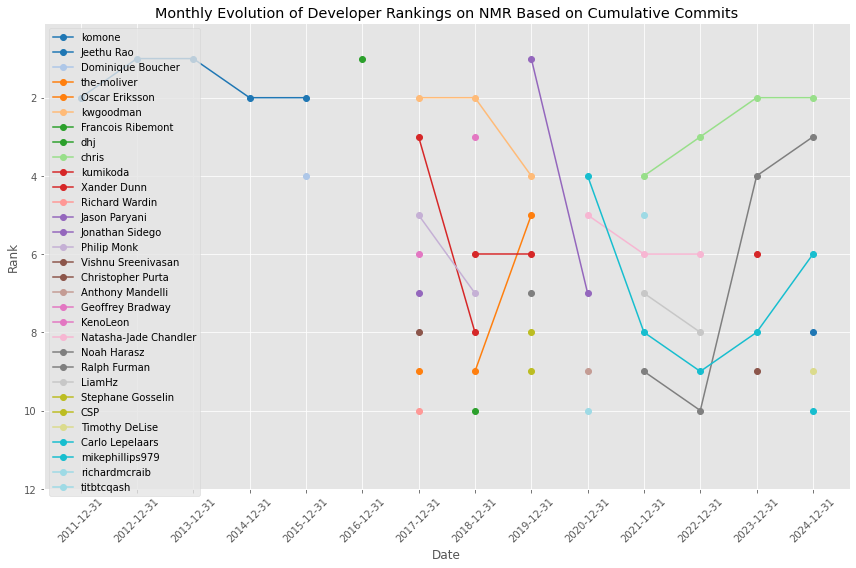

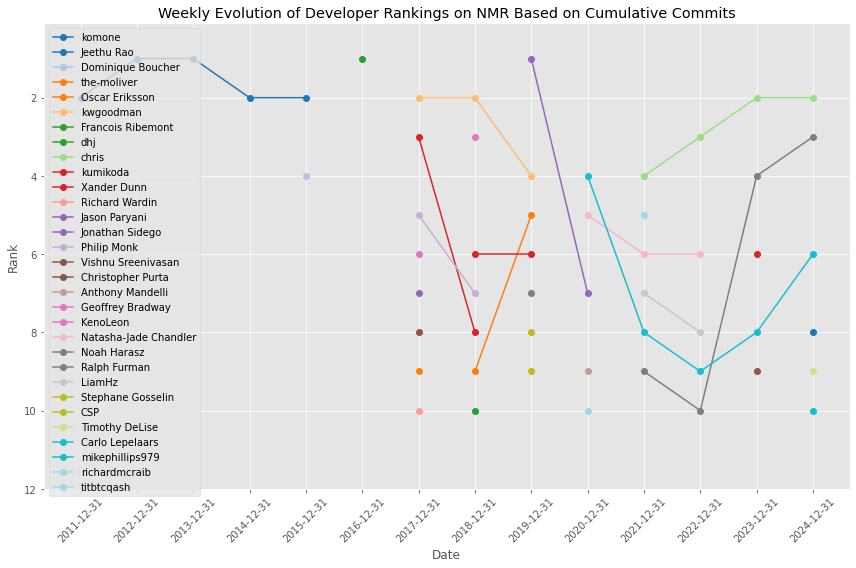

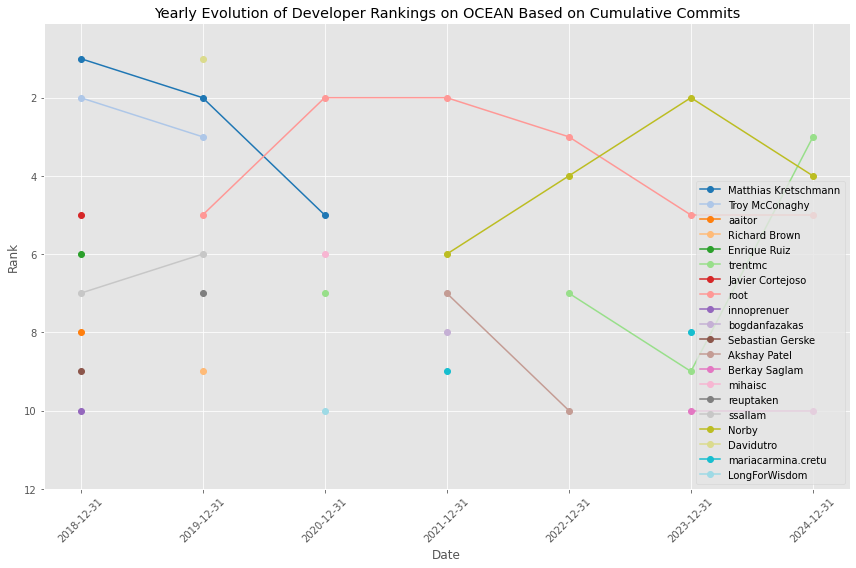

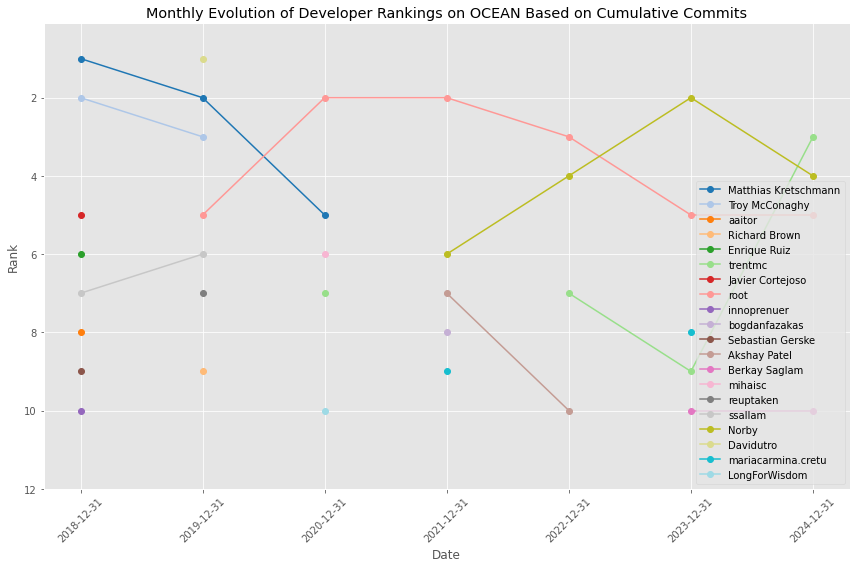

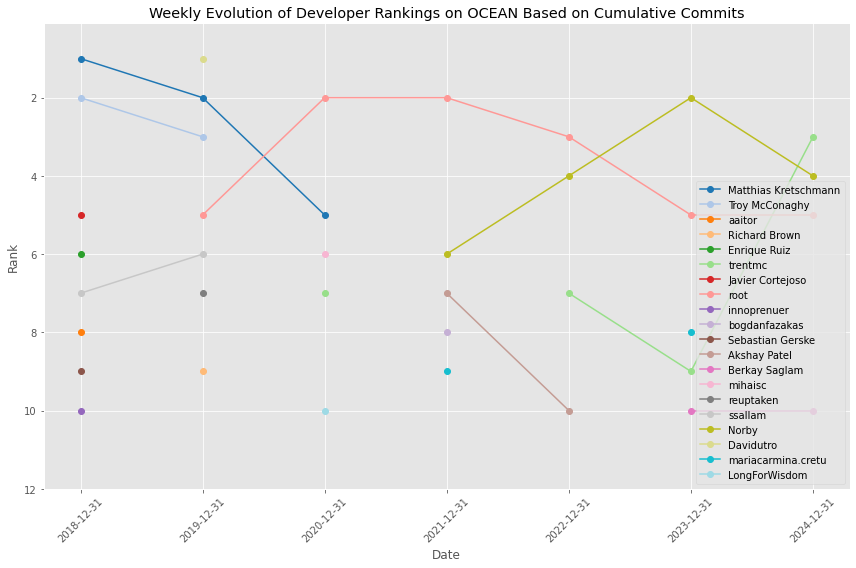

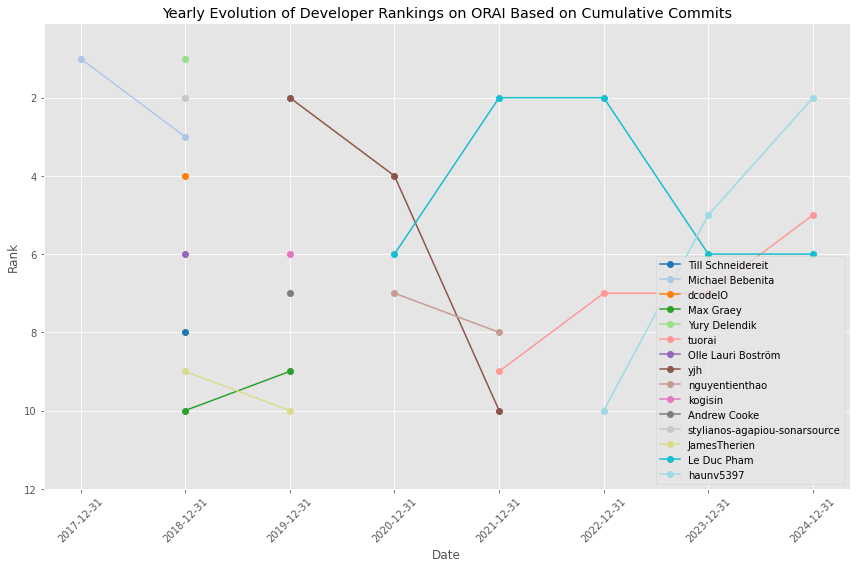

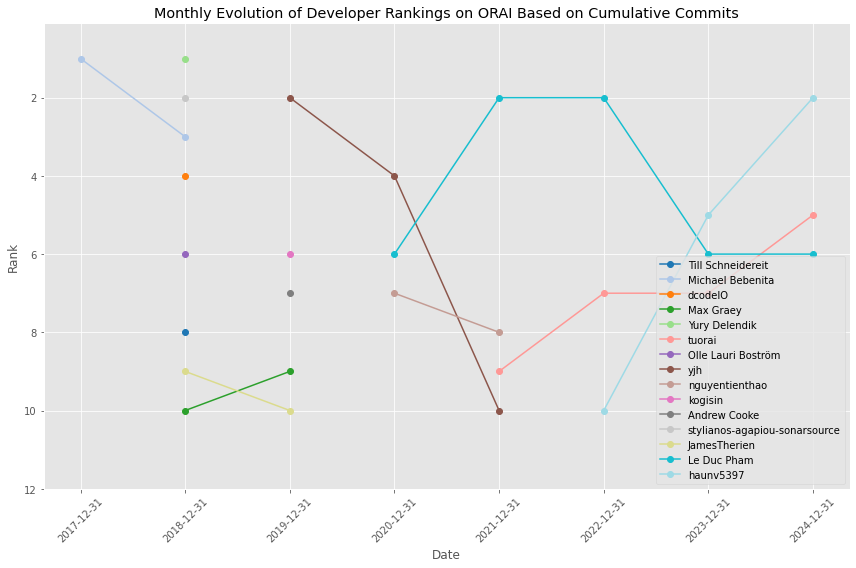

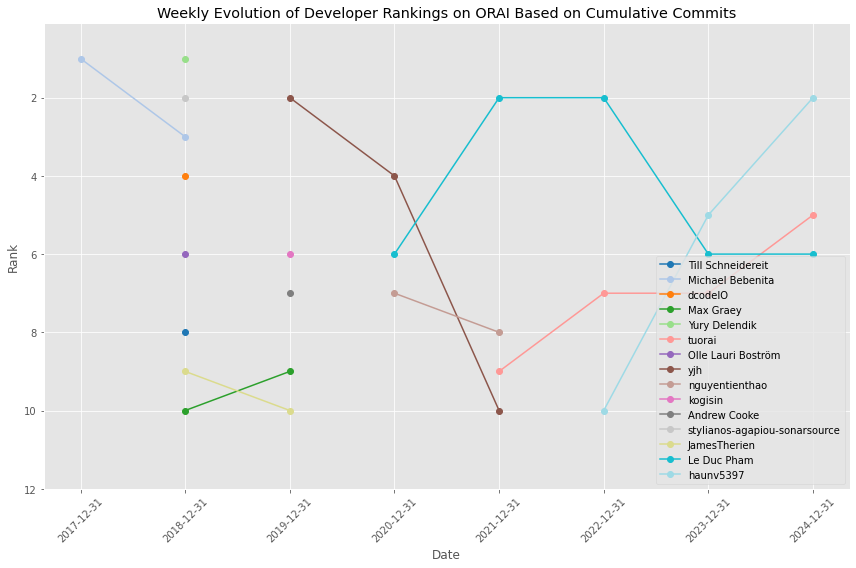

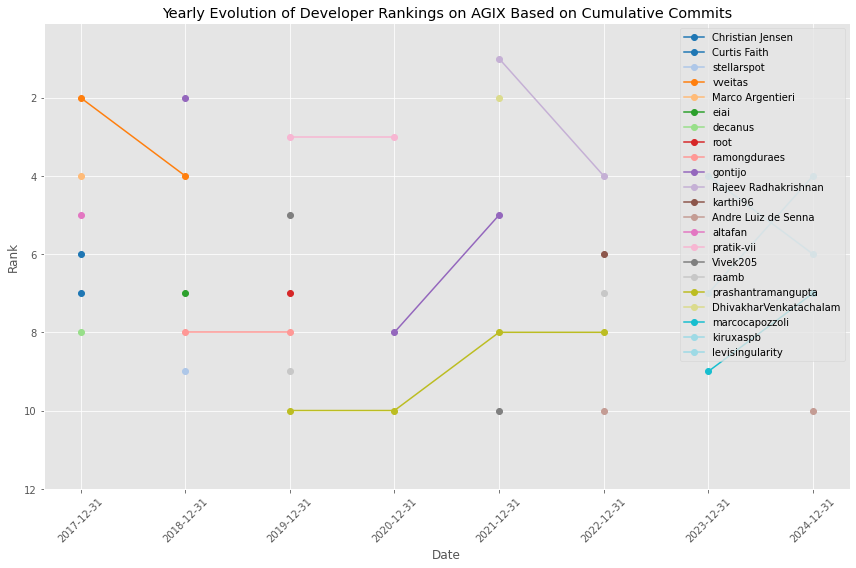

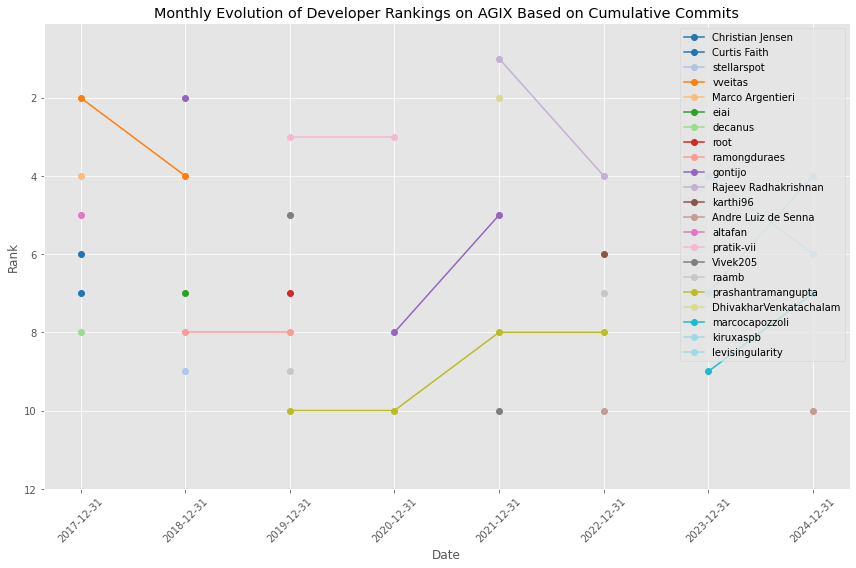

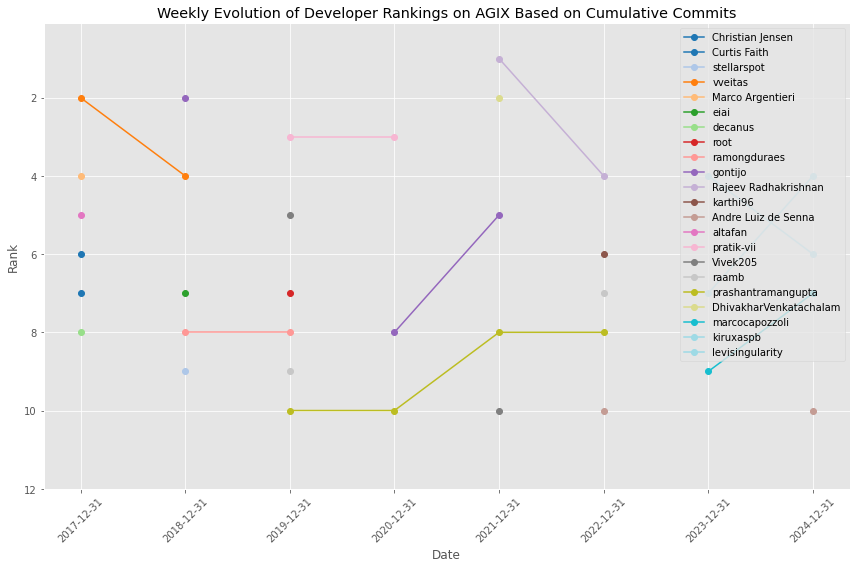

In [76]:
for i, token in enumerate(tokens):
    commits_data = get_commits(token, commits_mapping)
    year_commit_trend, month_commit_trend, week_commit_trend = get_commit_trends(commits_data)
    year_commit_rank = preprocess_trends(year_commit_trend, token)
    month_commit_rank = preprocess_trends(month_commit_trend, token)
    week_commit_trend = preprocess_trends(week_commit_trend, token)
    
    plot_evolution_graph(year_commit_rank, 'Yearly', token)
    
    plot_evolution_graph(year_commit_rank, 'Monthly', token)
    
    plot_evolution_graph(year_commit_rank, 'Weekly', token)